In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import time

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Pour activer la croissance de la mémoire pour un GPU spécifique
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
tf.debugging.set_log_device_placement(True)

1 Physical GPUs, 1 Logical GPUs


# Load Small dataset 
(with small trees)

In [70]:
path_to_label = "small_scaled_params_TiPS.csv"
path_to_label2 = "small_scaled_params_TiPS2.csv"
path_to_input = "small_CBLV_TiPS.npy"
path_to_input2 = "small_CBLV_TiPS2.npy"

params_to_infer = ["mean_signal", "amplitude", "incubation_rate", "recovery_rate", "import_param", "sampling_proba"]

nb_estimates = len(params_to_infer)
PROP_TRAIN =  0.96
# PROP_VAL = 0.1

inputs = np.transpose(np.load(path_to_input), axes=(0, 2, 1))
# inputs2 = np.transpose(np.load(path_to_input2), axes=(0, 2, 1))

labels = pd.read_csv(path_to_label)[params_to_infer].to_numpy()
# labels2 = pd.read_csv(path_to_label2)[params_to_infer].to_numpy()

# inputs = np.concatenate((inputs1, inputs2), axis=0)
# labels = np.concatenate((labels1, labels2), axis=0)
# #Check shapes
# print('inputs shape:', inputs1.shape)
# print('labels shape:', labels1.shape)
# print('inputs shape:', inputs2.shape)
# print('labels shape:', labels2.shape)
print("label concatenation: ", labels.shape)
print("input concatenation:", inputs.shape)
# # !!! shuffle before 
num_train = int(labels.shape[0]*PROP_TRAIN)

x_train, y_train = inputs[:num_train, :, :], labels[:num_train, :]
x_val, y_val = inputs[num_train:, :, :], labels[num_train:, :]

train_size = x_train.shape[0]
print(f"There is {train_size} training data, {x_val.shape[0]} validation data")

label concatenation:  (54653, 6)
input concatenation: (54653, 451, 2)
There is 52466 training data, 2187 validation data


# Design models

In [ ]:
SIZE = 451


FNN_small = keras.Sequential(
[
    keras.Input(shape=(SIZE,2)),
    layers.Dense(SIZE, activation="elu"),
    layers.Dropout(.5),
    layers.Dense(100, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="elu"),
#     layers.Dropout(.2),
    layers.Dense(16, activation="elu"),
#     layers.Dropout(.2),
    layers.Dense(8, activation="elu"),
#     layers.Dropout(.5),
    layers.Flatten(),
    layers.Dense(nb_estimates, activation="linear")
])

CNN_small1 = keras.Sequential(
    [
        keras.Input(shape=(SIZE, 2)),
        layers.Conv1D(filters=50, kernel_size=3),  ## !! normalement batch normalization puis relu apres conv 
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.Conv1D(filters=50, kernel_size=10),
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.MaxPooling1D(pool_size=10),
        layers.Conv1D(filters=80, kernel_size=10),
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="elu"),
        layers.Dropout(.2),
        layers.Dense(32, activation="elu"),
        layers.Dropout(.2),
        layers.Dense(16, activation="elu"),
        layers.Dropout(.2),
        layers.Dense(8, activation="elu"),
        layers.Dropout(0.0),
        layers.Dense(nb_estimates, activation="linear")
    ]
)


CNN_small2 = keras.Sequential(
    [
        keras.Input(shape=(SIZE, 2)),
        layers.Conv1D(filters=70, kernel_size=5),  
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.Conv1D(filters=70, kernel_size=10),
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.MaxPooling1D(pool_size=10),
        layers.Conv1D(filters=90, kernel_size=10),
        layers.BatchNormalization(),
        layers.Activation(keras.activations.relu),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(96, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(48, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(24, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(12, activation="elu"),
        layers.Dropout(.5),
        layers.Dense(nb_estimates, activation="linear")
    ]
)

#TEST
inp = tf.random.normal((1, SIZE,2))

print("FNN_small...")
FNN_small.summary()
print('out', FNN_small(inp).shape, '\n')

print("CNN_small1...")
# CNN_small1.summary()
print('out', CNN_small1(inp).shape, '\n')

print("CNN_small2...")
# CNN_small2.summary()
print('out', CNN_small2(inp).shape, '\n')

print("CNN_small3...")
# CNN_small3.summary()
print('out', CNN_small3(inp).shape, '\n')

# Training
## *Training function*
In order to avoid overfitting we apply an Early stopping when the validation loss does not change a lot during a certain amount of times (in addition with dropout in models)

In [85]:
def training(model, batch_size=400, num_epochs = 10000, patience=100, min_diff=0.5, loss= tf.keras.losses.MeanAbsolutePercentageError()):
    
    custom_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=min_diff, patience=patience)
    model.compile(
        optimizer="adam",
        loss=loss,
    )
    
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=num_epochs, callbacks=[custom_early_stop]);
    
    return history

## *Plot learning curves*

In [86]:
def plot_curves(name_model, history):
    num_real_epochs = len(history.history['loss'])
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure()
    plt.plot(np.arange(num_real_epochs), train_loss, '-r', label="Training loss")
    plt.plot(np.arange(num_real_epochs), val_loss, '-g', label="Validation loss")
    plt.xlabel('epoch')
    plt.legend()
    plt.title(name_model+": Learning curves for parameters inference")
    
    plt.show()

In [ ]:
start=time.time()
history_FNN = training(FNN_small, batch_size=800, patience=200, loss=tf.keras.losses.MeanSquaredError())
train_duration = time.time()-start 
print(f" Training with {train_size} training data took {train_duration/60} minutes")

plot_curves("FNN small", history_FNN)

Epoch 1/10000
66/66 [==============================] - 10s 137ms/step - loss: 13.8470 - val_loss: 9.3447
Epoch 2/10000
66/66 [==============================] - 9s 131ms/step - loss: 8.7199 - val_loss: 8.7210
Epoch 3/10000
66/66 [==============================] - 9s 131ms/step - loss: 8.4342 - val_loss: 8.4460
Epoch 4/10000
66/66 [==============================] - 9s 131ms/step - loss: 8.2221 - val_loss: 8.9899
Epoch 5/10000
66/66 [==============================] - 9s 132ms/step - loss: 8.1153 - val_loss: 8.0903
Epoch 6/10000
66/66 [==============================] - 9s 132ms/step - loss: 8.0686 - val_loss: 8.3681
Epoch 7/10000
66/66 [==============================] - 9s 132ms/step - loss: 7.8580 - val_loss: 7.8785
Epoch 8/10000
66/66 [==============================] - 9s 133ms/step - loss: 7.8135 - val_loss: 8.0132
Epoch 9/10000
66/66 [==============================] - 9s 134ms/step - loss: 7.7881 - val_loss: 8.0757
Epoch 10/10000
66/66 [==============================] - 9s 133ms/step -

In [81]:
# FNN_small.save('FNN_small')
FNN_small.save('FNN_small_MSE')

INFO:tensorflow:Assets written to: FNN_small/assets


Epoch 1/10000
163/163 [==============================] - 17s 94ms/step - loss: 86.6810 - val_loss: 54.5568
Epoch 2/10000
163/163 [==============================] - 14s 88ms/step - loss: 53.8942 - val_loss: 48.5205
Epoch 3/10000
163/163 [==============================] - 14s 88ms/step - loss: 53.2012 - val_loss: 46.3911
Epoch 4/10000
163/163 [==============================] - 14s 88ms/step - loss: 48.2400 - val_loss: 46.8978
Epoch 5/10000
163/163 [==============================] - 14s 88ms/step - loss: 51.9707 - val_loss: 46.0957
Epoch 6/10000
163/163 [==============================] - 14s 88ms/step - loss: 47.3804 - val_loss: 45.2616
Epoch 7/10000
163/163 [==============================] - 14s 88ms/step - loss: 47.4487 - val_loss: 45.8783
Epoch 8/10000
163/163 [==============================] - 14s 88ms/step - loss: 46.9770 - val_loss: 44.9858
Epoch 9/10000
163/163 [==============================] - 14s 88ms/step - loss: 46.5315 - val_loss: 43.5618
Epoch 10/10000
163/163 [=============

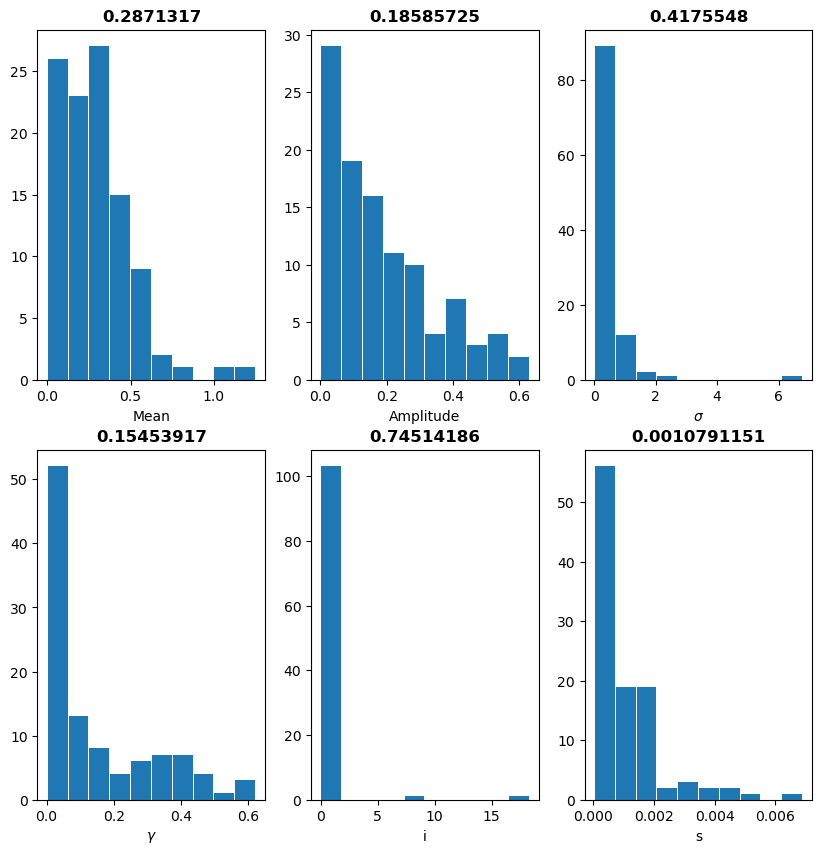

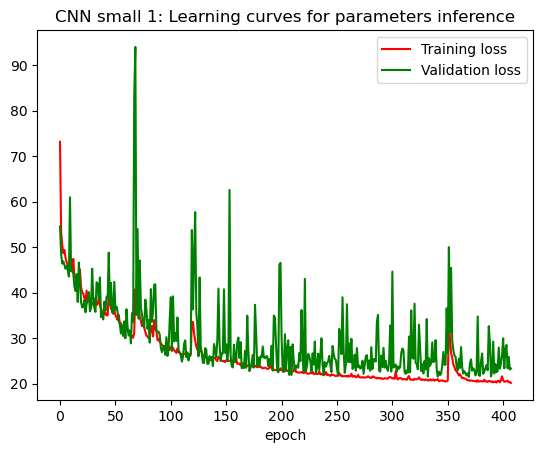

In [21]:
start=time.time()
history_1 = training(CNN_small1, batch_size=80, patience=200, loss=tf.keras.losses.MeanSquaredError())
train_duration = time.time()-start 
print(f" Training with {train_size} training data took {train_duration/60} minutes")

plot_curves("CNN small 1", history_1)

In [25]:
# Save the model 
CNN_small1.save("CNN_small_1")

INFO:tensorflow:Assets written to: CNN_small_1/assets


Epoch 1/10000
163/163 [==============================] - 24s 138ms/step - loss: 147.5138 - val_loss: 59.7913
Epoch 2/10000
163/163 [==============================] - 22s 133ms/step - loss: 79.7032 - val_loss: 51.0763
Epoch 3/10000
163/163 [==============================] - 22s 132ms/step - loss: 62.9623 - val_loss: 50.2177
Epoch 4/10000
163/163 [==============================] - 22s 132ms/step - loss: 61.1750 - val_loss: 47.8973
Epoch 5/10000
163/163 [==============================] - 22s 132ms/step - loss: 53.7138 - val_loss: 47.4222
Epoch 6/10000
163/163 [==============================] - 22s 133ms/step - loss: 51.1080 - val_loss: 47.0889
Epoch 7/10000
163/163 [==============================] - 22s 133ms/step - loss: 49.7919 - val_loss: 46.8842
Epoch 8/10000
163/163 [==============================] - 22s 133ms/step - loss: 48.4694 - val_loss: 46.6936
Epoch 9/10000
163/163 [==============================] - 22s 132ms/step - loss: 48.7671 - val_loss: 46.7075
Epoch 10/10000
163/163 [===

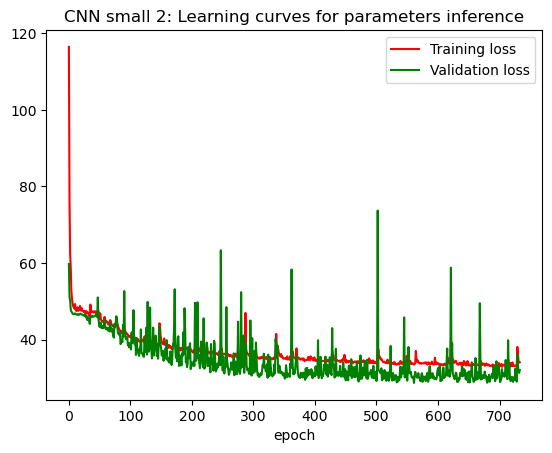

In [46]:
start=time.time()
history_2 = training(CNN_small2, batch_size=800, patience=200)
train_duration = time.time()-start 
print(f" Training with {train_size} training data took {train_duration/60} minutes")

plot_curves("CNN small 2", history_2)

In [47]:
CNN_small2.save("CNN_small_2")

INFO:tensorflow:Assets written to: CNN_small_2/assets


# Testing

In [6]:
mod1 = keras.models.load_model("CNN_small_1")
mod2 = keras.models.load_model("CNN_small_2")

In [8]:
# Load test data
params_to_infer = ["mean_signal", "amplitude", "incubation_rate", "recovery_rate", "import_param", "sampling_proba"]

test_input = np.transpose(np.load("Test/small_test_CBLV.npy"), axes=(0, 2, 1))
test_label = pd.read_csv("Test/small_test_scaled_params.csv")[params_to_infer].to_numpy()

print('input shape', test_input.shape)
print('label shape', test_label.shape)

input shape (439, 451, 2)
label shape (439, 6)


## *MRE: Mean Relative Error* 
To assess the accurary of parameter estimation, I compute the mean absolute relative error between the true parameter values (or target) and the predicted values for machine learning approaches. I used more the 100 simulated test trees. I choose this metric in order to compare the accurary with the one obtained in the Voznica's article.

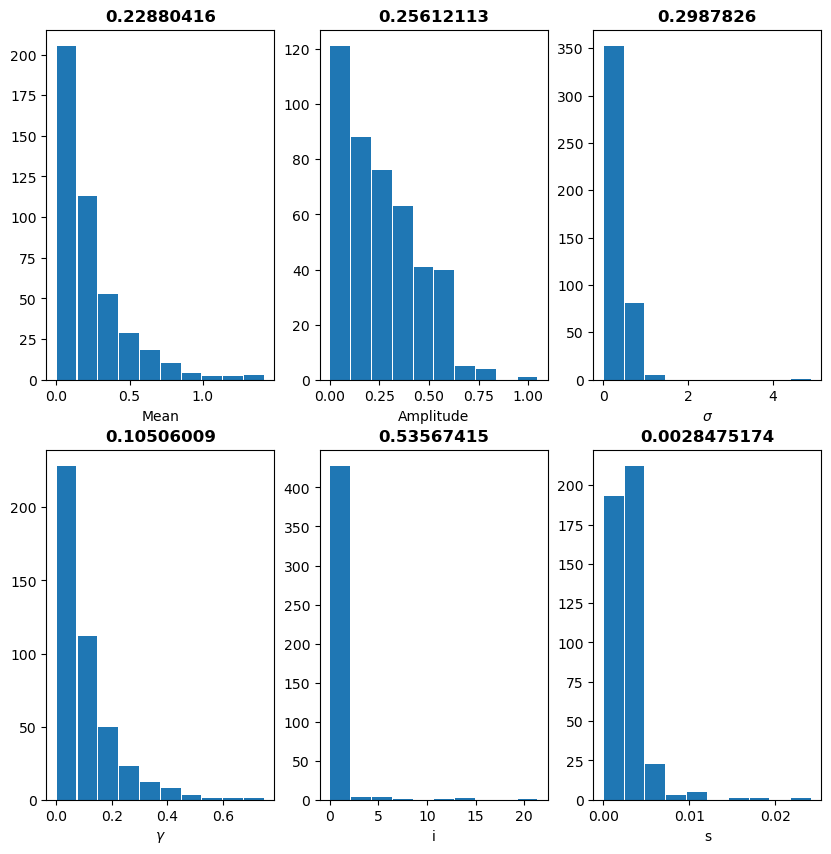

In [10]:
def compute_error(model, inputs=test_input, labels=test_label, plot=True):
    
    RE = tf.math.abs(labels - model(inputs))/labels
    MRE = tf.reduce_mean(RE, axis=0).numpy()
    
    # PLot RE for each test tree and each parameter
    if plot:
        fig = plt.figure(figsize=(10, 10))
        
        fig.add_subplot(231)
        plt.hist(RE[:,0], rwidth=0.95)
        plt.title(str(MRE[0]), fontweight='bold')
        plt.xlabel("Mean")
        
        fig.add_subplot(232)
        plt.hist(RE[:,1], rwidth=0.95)
        plt.xlabel('Amplitude')
        plt.title(str(MRE[1]), fontweight='bold')
        
        fig.add_subplot(233)
        plt.hist(RE[:,2],rwidth=0.95)
        plt.xlabel('$\sigma$')
        plt.title(str(MRE[2]), fontweight='bold')
        
        fig.add_subplot(234)
        plt.hist(RE[:,3],rwidth=0.95)
        plt.xlabel('$\gamma$')
        plt.title(str(MRE[3]), fontweight='bold')
        
        fig.add_subplot(235)
        plt.hist(RE[:,4],rwidth=0.95)
        plt.xlabel('i')
        plt.title(str(MRE[4]), fontweight='bold')
        
        fig.add_subplot(236)
        plt.hist(RE[:,5], rwidth=0.95)
        plt.xlabel("s")
        plt.title(str(MRE[5]), fontweight='bold')
                            
        return fig
        
    else:
        return(RE, MRE)

compute_error(mod1)

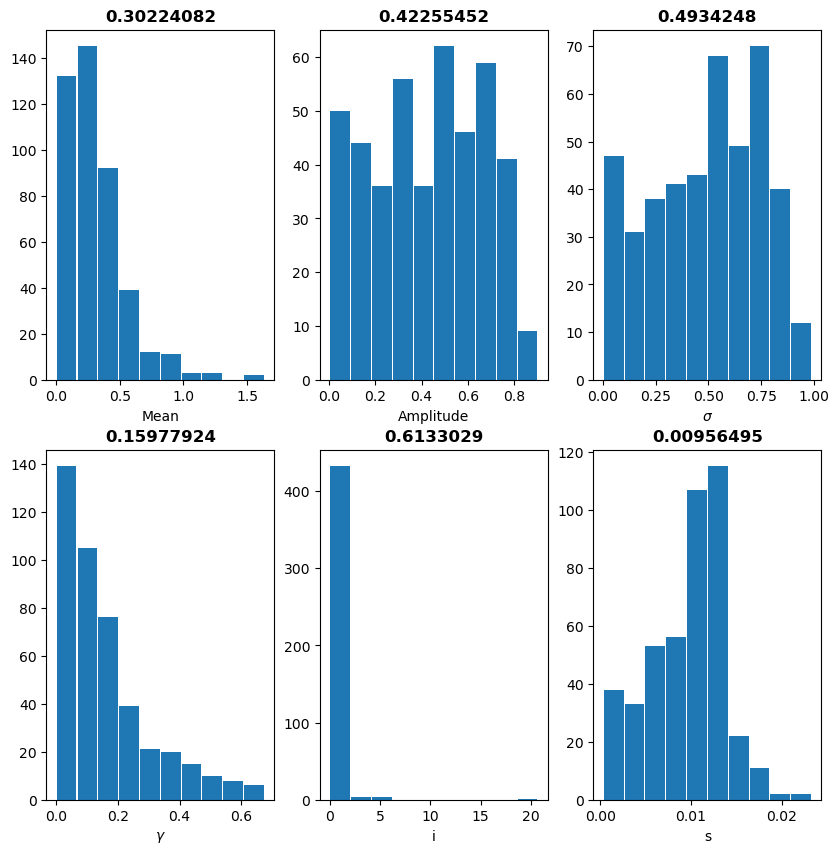

In [11]:
compute_error(mod2)

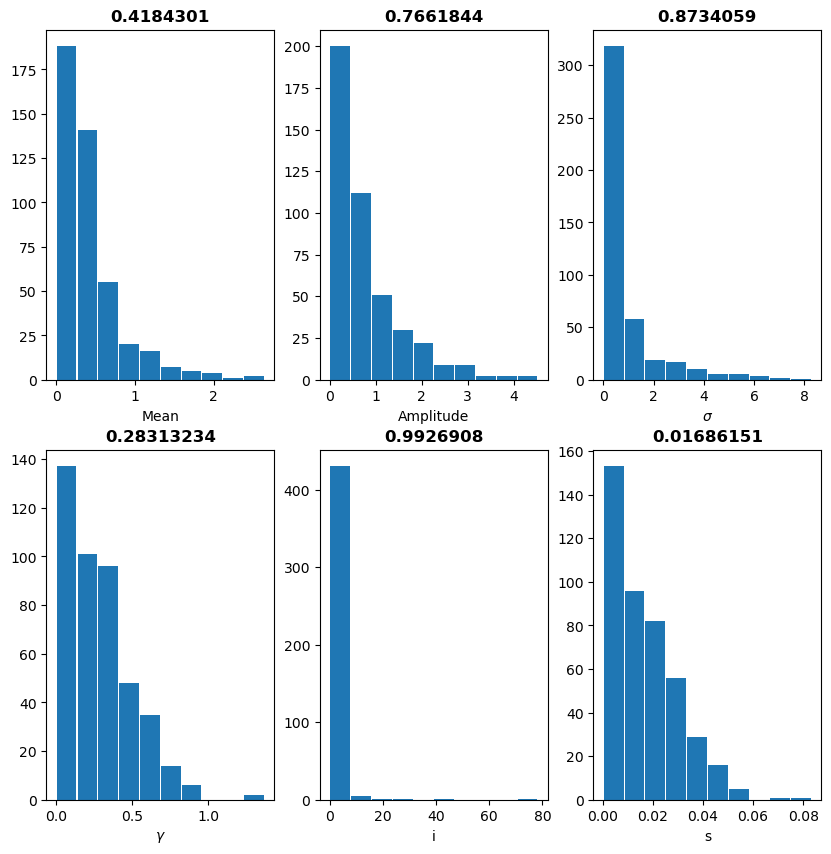

In [88]:
compute_error(FNN_small)

(439, 2)


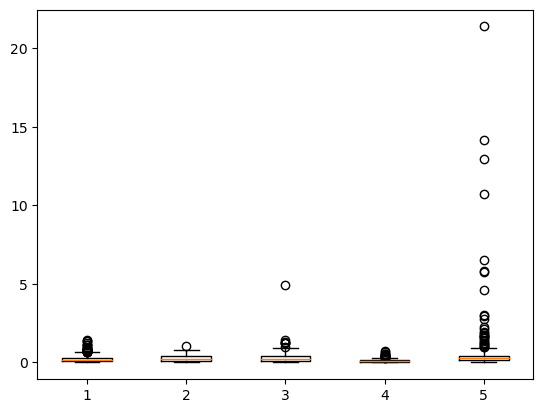

In [48]:
plt.boxplot(RE1[:,:-1].numpy(), positions=np.arange(1,6))
plt.show()

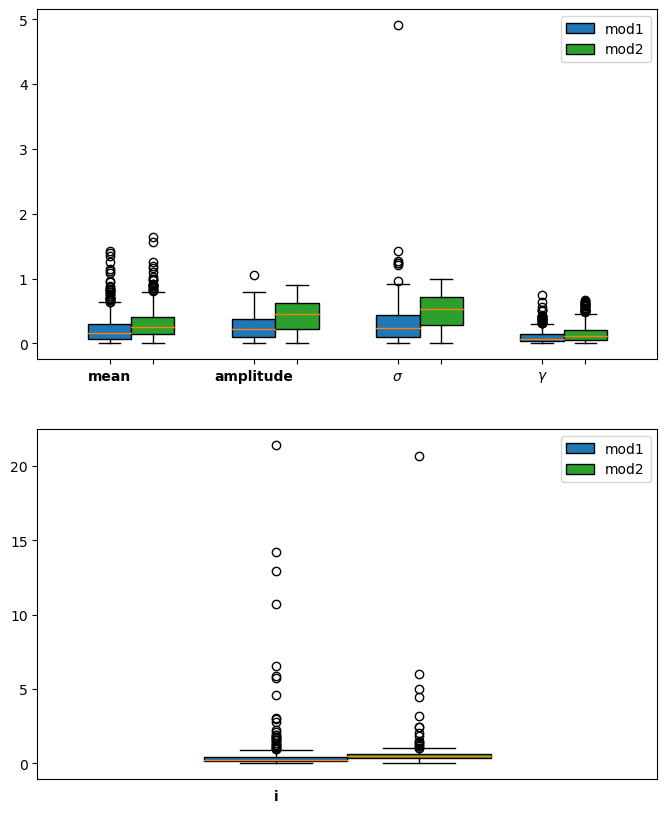

In [65]:
RE1, _ = compute_error(mod1, plot=False)
RE2, _ = compute_error(mod2, plot=False)

fig, ax = plt.subplots(2,1, figsize=(8,10))
t=np.arange(1,5)
bp1 = ax[0].boxplot(RE1[:,:-2].numpy(),positions=t, notch=False, widths=0.2, 
                 patch_artist=True, boxprops=dict(facecolor="C0"))

bp2 = ax[0].boxplot(RE2[:,:-2].numpy(), positions=t+0.2, notch=False, widths=0.2, 
                 patch_artist=True, boxprops=dict(facecolor="C2"))

ax[0].legend([bp1["boxes"][0], bp2["boxes"][0]], ['mod1', 'mod2'], loc='upper right')

ax[0].set_xticklabels(['mean', 'amplitude', '$\sigma$', '$\gamma$', '', '', '', ''], fontweight='bold')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False)         # ticks along the top edge are off

bp3= ax[1].boxplot(RE1[:,4], positions=[1], notch=False, widths=0.2, 
                 patch_artist=True, boxprops=dict(facecolor="C0"))
bp4 = ax[1].boxplot(RE2[:, 4], positions=[1.2], notch=False, widths=0.2,
                   patch_artist=True, boxprops=dict(facecolor="C2"))

ax[1].legend([bp3["boxes"][0], bp4["boxes"][0]], ['mod1', 'mod2'], loc='upper right')

ax[1].set_xticklabels(['i', ''], fontweight='bold')

plt.show()